Hani Park (hani.park@uni-potsdam.de)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

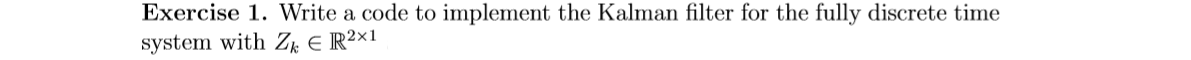

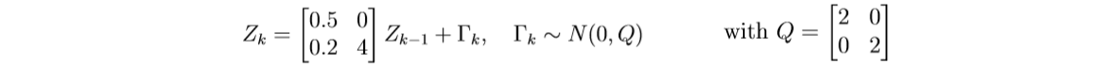

- A : state transition matrix of dynamic system (2 X 2 constant matrix)
- Q : noise covariance of dynamic system (2 x 2 constant matrix)
- H : forward map of observing model (1 X 2 constant vector)
- R : noice covariance of observing model (constant)
- E_init : mean of initial distribution of Z (2 X 1 vector)
- P_init : covariance of initial distribution of Z (2 X 2 matrix)
- Z_init : initial state of dynamic system (2 X 1 vector)

In [29]:
#A = np.array([[0.5, 0],[0.2, 4]])
A = np.array([[-0.5, 0.6],[-0.1, 0.1]])
Q = np.array([[2, 0],[0, 2]])
H = np.array([[1, 0]])
R = 3
E_init = np.array([[0],[0]])
P_init = np.diag([100, 100]) # please refer to the note below
Z_init = np.array([[np.random.normal(0,1)],[np.random.normal(0,1)]]) 
Z_init = np.array([[1],[1]])

n_steps = 200 # number of time steps

<Font color=blue> I adjusted the initial covariance because the given 1 seemed too small for the stage where we are very unsure about this initial value.


In [30]:
Z_ref_list = np.zeros(shape=(n_steps,2)) # list that stores true states at all time steps
Y_obs_list = np.zeros(shape=(n_steps)) # list that stores observation at all time steps
error_list = np.zeros(shape=(n_steps)) # list that stores residual between estimated state and true state
E_analysis_list = np.zeros(shape=(n_steps,2)) # list that stores E_analysis 
P_analysis_list = np.zeros(shape=(n_steps,2)) # list that stores E_analysis 

### Produce a reference trajectory of the dynamic system. 

In [34]:
def Forecast_Model (Z_previous):
    Z_current = np.dot(A, Z_previous) #+ np.reshape(np.random.multivariate_normal(np.array([0,0]),Q), (2,1))   
    return Z_current

def get_Z_ref_list (Z_init):
    Z_previous = Z_init
    for i in range(n_steps):
        Z_current = Forecast_Model(Z_previous)
        Z_ref_list[i] = np.reshape(Z_current, (1,2))
        Z_previous = Z_current
    return Z_ref_list

Z_ref_list = get_Z_ref_list(Z_init)

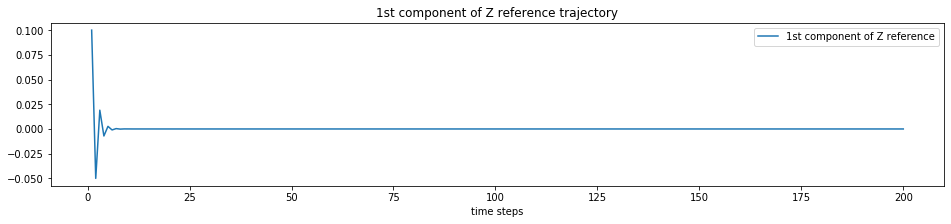

In [35]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), Z_ref_list[:,0])
ax.set(xlabel='time steps', title='1st component of Z reference trajectory')
ax.legend(['1st component of Z reference'])

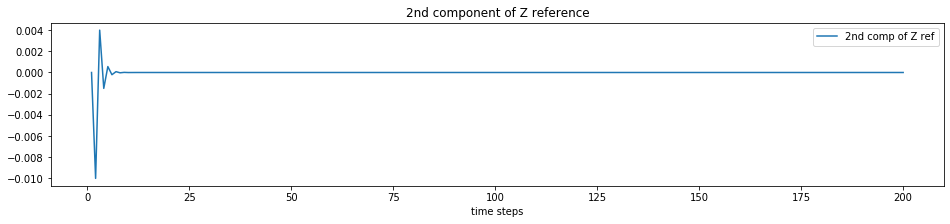

In [36]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), Z_ref_list[:,1])
ax.set(xlabel='time steps', title='2nd component of Z reference')
ax.legend(['2nd comp of Z ref'])

<Font color=purple> The 2nd component blows up!

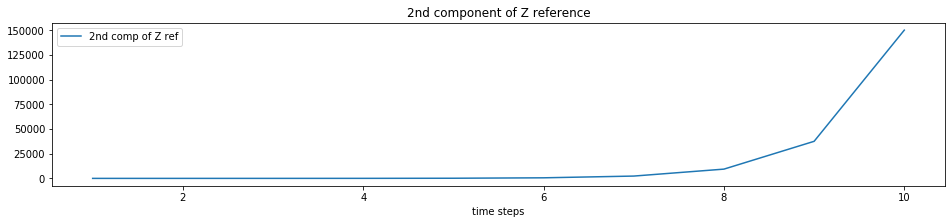

In [26]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,11), Z_ref_list[:10,1])
ax.set(xlabel='time steps', title='2nd component of Z reference')
ax.legend(['2nd comp of Z ref'])

<Font color=purple> Even after 10 times of recursions, it blows up abruptly!

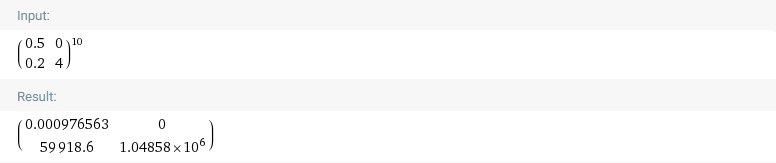

<Font color=Purple> Since the two eigenvalues of A are both positive, this linear state transition matrix is **unstable**.

### Obstain a obseravation (only for the 1st component of Z ref) at each time step

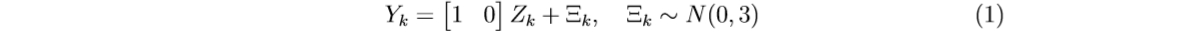

In [8]:
def Observing_Model (Z_ref, R):
    r = np.random.normal(0, np.sqrt(R)) # measurement noise
    Y_obs = np.dot(H, Z_ref) + r
    return Y_obs

def get_Obeservation (Z_ref_list, R):
    for i in range(n_steps):
        Y_obs_list[i] = Observing_Model(Z_ref_list[i], R)
    return Y_obs_list

Y_obs_list = get_Obeservation(Z_ref_list, R)

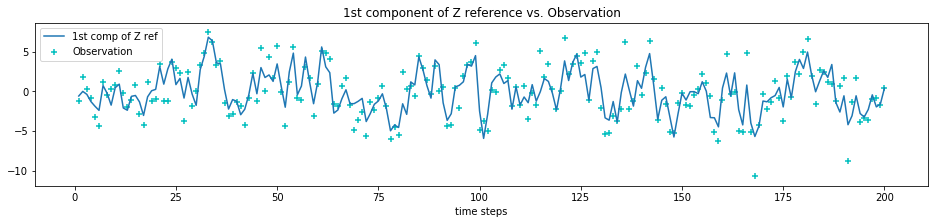

In [9]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), Z_ref_list[:,0])
ax.scatter(np.arange(1,201), Y_obs_list, marker='+', color='c')
ax.set(xlabel='time steps', title='1st component of Z reference vs. Observation')
ax.legend(['1st comp of Z ref','Observation'])

### Implement the Prediction step

From the text book:

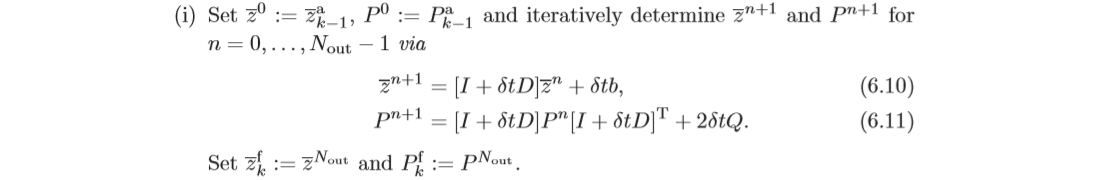

- E_previous : mean of the system state at the previous step k-1 (2 X 1 vector)
- P_previous : covariance of the system state at the previous step k-1 (2 x 2 matrix)
- E_forecast : predicted mean of the system state at the current step k (2 X 1 vector)
- P_forecast : predicted covariance of the system state at the current step k (2 x 2 matrix)
- A : transition matrix (2 x 2 matrix)
- Q : noise covariance matrix (2 x 2 matrix)

In [10]:
def Prediction (E_previous, P_previous):
    E_forecast = np.dot(A, E_previous)
    P_forecast = np.dot(np.dot(A, P_previous), A.T) + Q
    return E_forecast, P_forecast

### Implement the Update step

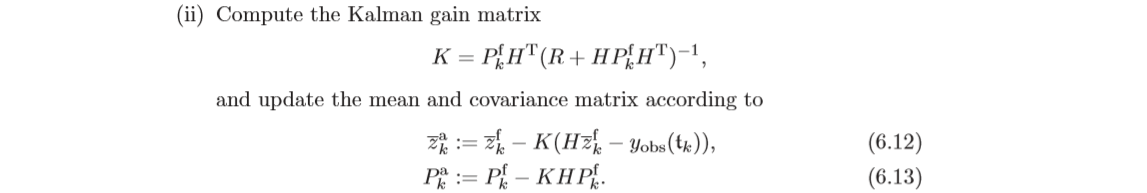

- E_forecast : mean of prior distribution of Z (2 x 1 vector)
- P_forecast : covariance of prior distribution of Z (2 x 2 matrix)
- K : Kalman gain matrix (2 X 1 vector)
- E_analysis : mean of the postrior distribution of Z (2 x 1 vector)
- P_analysis : covariance of the postrior distribution of Z (2 x 2 matrix)

In [11]:
def Assimilation (E_forecast, P_forecast, Y_obs, R):
    K = np.dot((np.dot(P_forecast, H.T)), np.linalg.inv(R + np.dot((np.dot(H, P_forecast)), H.T)))
    E_analysis = E_forecast - np.dot(K, (np.dot(H, E_forecast) - Y_obs))
    P_analysis = P_forecast - np.dot(np.dot(K, H), P_forecast)
    return E_analysis, P_analysis

### Kalman filter

<font color=blue> We will do the **update step first** since we have an observation at the first time step (i==0).

In [12]:
def KalmanFilter(E_init, P_init):
    E_forecast, P_forecast = E_init, P_init
    for i in range(n_steps):
        Y_obs = Y_obs_list[i]
        # Update/Assimilation step
        E_analysis, P_analysis = Assimilation (E_forecast, P_forecast, Y_obs, R)
        E_analysis_list[i] = np.reshape(E_analysis, (2,))   
        P_analysis_list[i] = np.reshape([P_analysis[0,0], P_analysis[1,1]], (2,))
        E, P = E_analysis, P_analysis
        # Prediction step
        E_forecast, P_forecast = Prediction(E, P)
    return E_analysis_list, P_analysis_list

In [13]:
E_analysis_list, P_analysis_list  = KalmanFilter(E_init, P_init)

### Brief view on how the Kalman filter worked

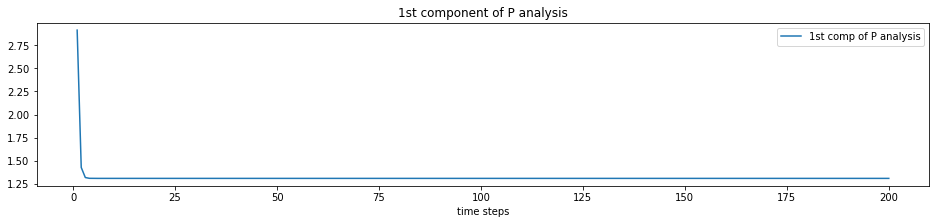

In [14]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), P_analysis_list[:,0])
ax.set(xlabel='time steps', title='1st component of P analysis')
ax.legend(['1st comp of P analysis'])

<font color=purple> **The variance of the first component converges very quickly.** 

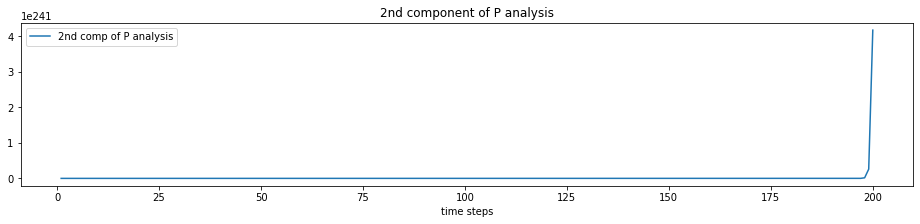

In [15]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), P_analysis_list[:,1])
ax.set(xlabel='time steps', title='2nd component of P analysis')
ax.legend(['2nd comp of P analysis'])

<font color=purple> **The variance of the second component exponentially increase.** 

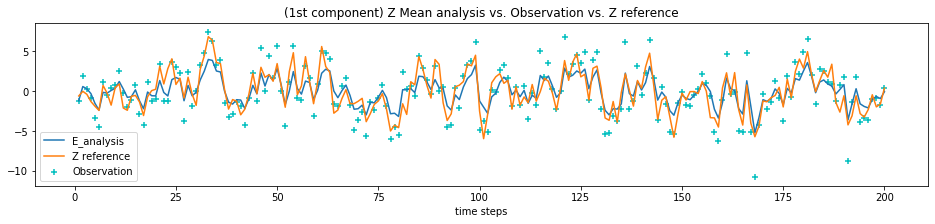

In [16]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), E_analysis_list[:,0], label='E_analysis')
ax.scatter(np.arange(1,201), Y_obs_list, marker='+', color='c', label='Observation')
ax.plot(np.arange(1,201), Z_ref_list[:,0], label='Z reference')
ax.set(xlabel='time steps', title='(1st component) Z Mean analysis vs. Observation vs. Z reference')
ax.legend()

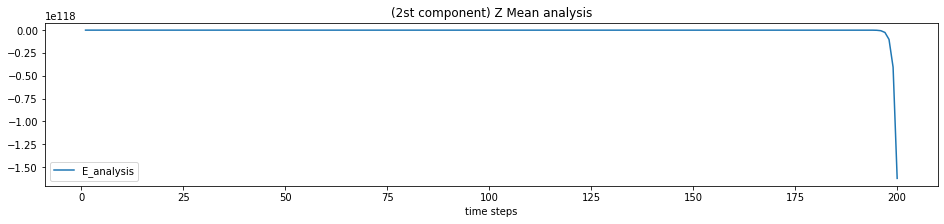

In [17]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), E_analysis_list[:,1], label='E_analysis')
ax.set(xlabel='time steps', title='(2st component) Z Mean analysis') # No observation for the 2nd component
ax.legend()

### Now let's go through the exercise questions!

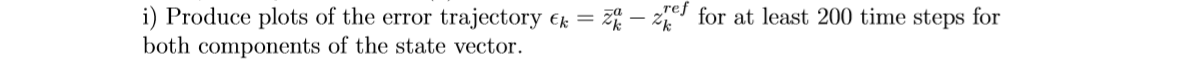

In [18]:
error_list = E_analysis_list - Z_ref_list

RMSE : 0.094675


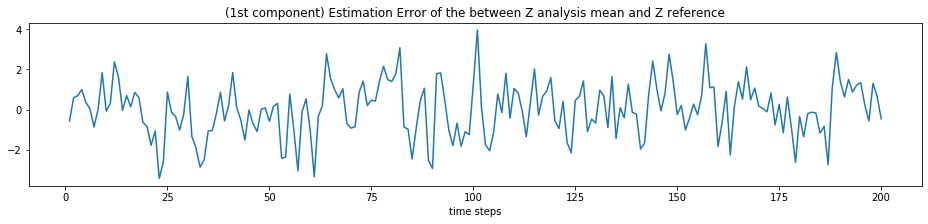

In [19]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), error_list[:,0])
ax.set(xlabel='time steps', title='(1st component) Estimation Error of the between Z analysis mean and Z reference')
print('RMSE : {}'.format(round(np.sqrt(sum(error_list[:,0]**2))/n_steps, 6)))

RMSE : 8.09597957396932e+117


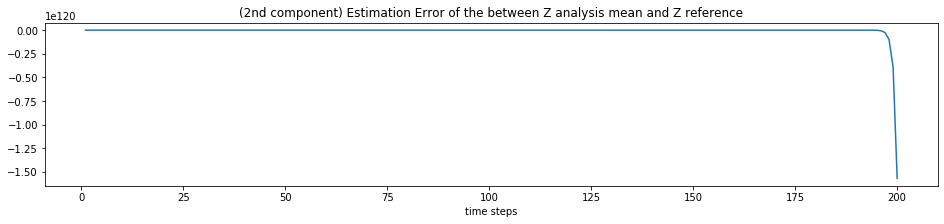

In [20]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), error_list[:,1])
ax.set(xlabel='time steps', title='(2nd component) Estimation Error of the between Z analysis mean and Z reference')
print('RMSE : {}'.format(round(np.sqrt(sum(error_list[:,1]**2))/n_steps, 6)))

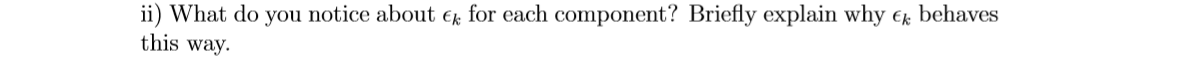

- <Font color=purple> **Estimate error of the first component: the error trajectory stays within certain boundaries.** <br>
- <Font color=purple> **Estimate error of the second component: exponential growth of errors** <br>
    (As it can be seen previously, the variance of the second component exponentially increases because of the **unstable linear transition matrix**.  

#### <Font color=green> Case 1: when R decreases ; we are more confident about the observation.

In [21]:
R = 1 # previously R=3
Y_obs_list = get_Obeservation(Z_ref_list, R)
E_analysis_list, P_analysis_list  = KalmanFilter(E_init, P_init)
error_list = E_analysis_list - Z_ref_list

RMSE : 0.070387


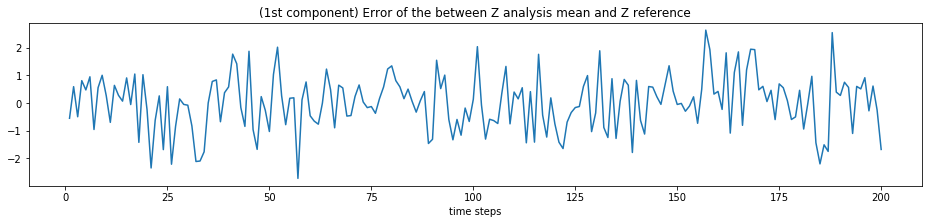

In [22]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), error_list[:,0])
ax.set(xlabel='time steps', title='(1st component) Error of the between Z analysis mean and Z reference')
print('RMSE : {}'.format(round(np.sqrt(sum(error_list[:,0]**2))/n_steps, 6)))

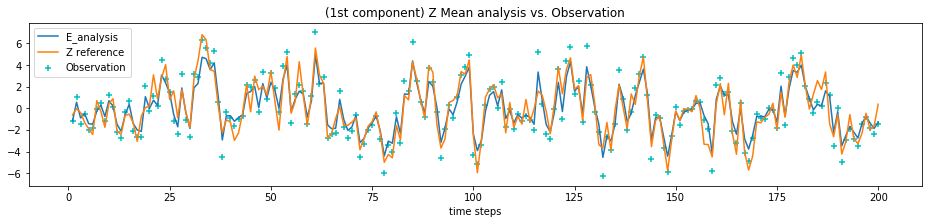

In [23]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), E_analysis_list[:,0], label='E_analysis')
ax.scatter(np.arange(1,201), Y_obs_list, marker='+', color='c', label='Observation')
ax.plot(np.arange(1,201), Z_ref_list[:,0], label='Z reference')
ax.set(xlabel='time steps', title='(1st component) Z Mean analysis vs. Observation')
ax.legend()

<Font color=purple> **The estimation errors becomes smaller with a smaller R**

RMSE : 8.166984814708657e+117


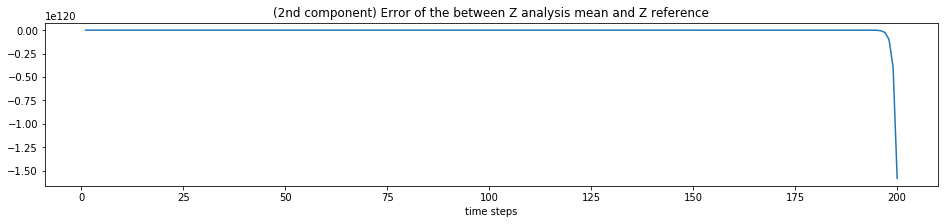

In [24]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), error_list[:,1])
ax.set(xlabel='time steps', title='(2nd component) Error of the between Z analysis mean and Z reference')
print('RMSE : {}'.format(round(np.sqrt(sum(error_list[:,1]**2))/n_steps, 6)))

<Font color=purple> However, changing R does not affect the second component because we only observe the first component. We need to find another remedy.

#### Let's inspect further varing R values.

In [25]:
def get_RMSE(R_value):
    R = R_value
    Y_obs_list = get_Obeservation(Z_ref_list, R)
    E_analysis_list, P_analysis_list  = KalmanFilter(E_init, P_init)
    error_list = E_analysis_list - Z_ref_list
    return np.sqrt(sum(error_list[:,0]**2))/n_steps

RMSE_list = []
for i in np.linspace(0,10,100):
    RMSE_list.append(get_RMSE(i))

[Text(0.5, 0, 'R (observation noise)'), Text(0.5, 1.0, 'RMSE')]

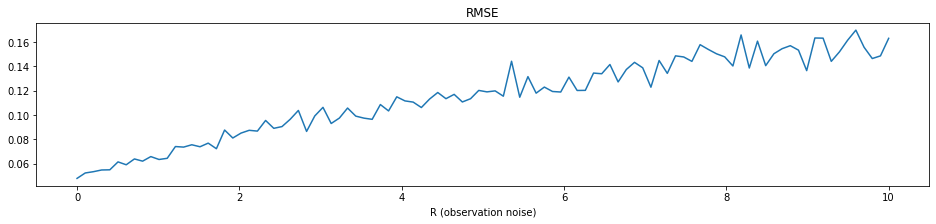

In [26]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.linspace(0,10,100), RMSE_list)
ax.set(xlabel='R (observation noise)', title='RMSE')

<Font color=purple> **Decreasing R leads to smaller estimation errors** (based on RMSE)

#### <Font color=green> Case 2: When both of the two components are observed (R remained)

In [27]:
H = np.eye(2) # identity matrix: np.array([[1,0],[0,1]])
Y_obs_list2 = np.zeros(shape=(n_steps,2))

def Observing_Model2 (Z_ref):
    r1 = np.random.normal(0, np.sqrt(3)) # measurement noise
    r2 = np.random.normal(0, np.sqrt(3))
    Y_obs = np.dot(H, Z_ref) + np.array([[r1,r2]])
    return Y_obs

def get_Obeservation2 (Z_ref_list):
    for i in range(n_steps):
        Y_obs_list2[i,:] = Observing_Model2(Z_ref_list[i])
    return Y_obs_list2

def KalmanFilter2(E_init, P_init):
    E, P = E_init, P_init
    for i in range(n_steps):
        E_forecast, P_forecast = Prediction(E, P)
        Y_obs = Y_obs_list2[i,:]
        E_analysis, P_analysis = Assimilation (E_forecast, P_forecast, Y_obs, R)
        E_analysis_list[i] = np.reshape(np.array([E_analysis[1,0],E_analysis[0,1]]), (2,))   
        P_analysis_list[i] = np.reshape([P_analysis[0,0], P_analysis[1,1]], (2,))
        E, P = E_analysis, P_analysis
    return E_analysis_list, P_analysis_list

Y_obs_list2 = get_Obeservation2(Z_ref_list)
E_analysis_list, P_analysis_list  = KalmanFilter2(E_init, P_init)
error_list = E_analysis_list - Z_ref_list

RMSE : 0.093722


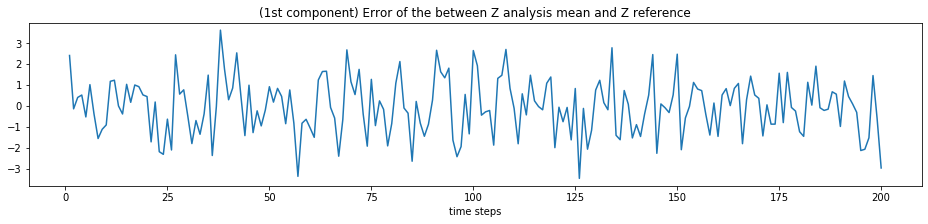

In [28]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), error_list[:,0])
ax.set(xlabel='time steps', title='(1st component) Error of the between Z analysis mean and Z reference')
print('RMSE : {}'.format(round(np.sqrt(sum(error_list[:,0]**2))/n_steps, 6)))

<Font color=purple> It is obvious that observing the additional component (the second component) is not helpful for estimating the first component. 

RMSE : 2.234858817807371e+117


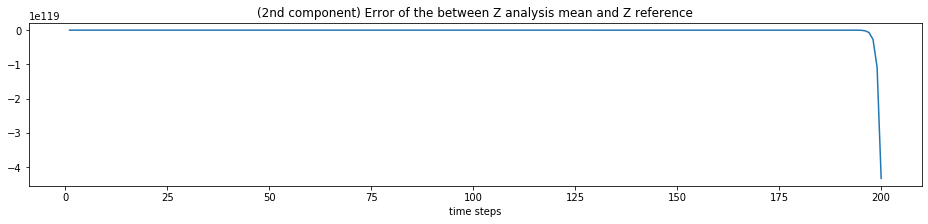

In [29]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), error_list[:,1])
ax.set(xlabel='time steps', title='(2nd component) Error of the between Z analysis mean and Z reference')
print('RMSE : {}'.format(round(np.sqrt(sum(error_list[:,1]**2))/n_steps, 6)))

<Font color=purple> **On the other hand, observing the second component, to some extent, reduces the estimation error for the second component.**

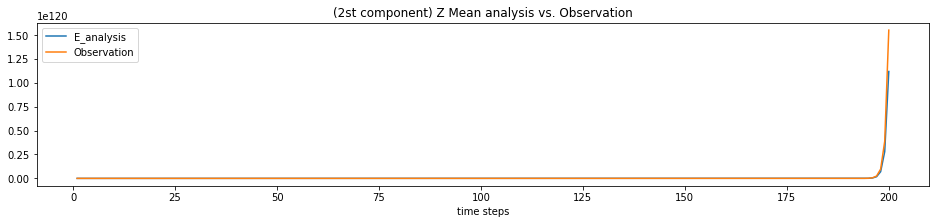

In [30]:
fig, ax = plt.subplots(figsize=(16,3))
ax.plot(np.arange(1,201), E_analysis_list[:,1], label='E_analysis')
ax.plot(np.arange(1,201), Y_obs_list2[:,1], label='Observation')
ax.set(xlabel='time steps', title='(2st component) Z Mean analysis vs. Observation')
ax.legend()